# 卷积神经网络基础

本节我们介绍卷积神经网络的基础概念，主要是卷积层和池化层，并解释填充、步幅、输入通道和输出通道的含义。

## 二维卷积层

本节介绍的是最常见的二维卷积层，常用于处理图像数据。

### 二维互相关运算

二维互相关（cross-correlation）运算的输入是一个二维输入数组和一个二维核（kernel）数组，输出也是一个二维数组，其中核数组通常称为卷积核或过滤器（filter）。卷积核的尺寸通常小于输入数组，卷积核在输入数组上滑动，在每个位置上，卷积核与该位置处的输入子数组按元素相乘并求和，得到输出数组中相应位置的元素。图1展示了一个互相关运算的例子，阴影部分分别是输入的第一个计算区域、核数组以及对应的输出。

![Image Name](https://cdn.kesci.com/upload/image/q5nfdbhcw5.png?imageView2/0/w/640/h/640)
图1 二维互相关运算

下面我们用`corr2d`函数实现二维互相关运算，它接受输入数组`X`与核数组`K`，并输出数组`Y`。
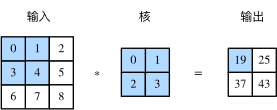

In [1]:
import torch 
import torch.nn as nn

def corr2d(X, K):
    H, W = X.shape
    h, w = K.shape
    Y = torch.zeros(H - h + 1, W - w + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

构造上图中的输入数组`X`、核数组`K`来验证二维互相关运算的输出。

In [2]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
Y = corr2d(X, K)
print(Y)

tensor([[19., 25.],
        [37., 43.]])


### 二维卷积层

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏置来得到输出。卷积层的模型参数包括卷积核和标量偏置。

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

下面我们看一个例子，我们构造一张$6 \times 8$的图像，中间4列为黑（0），其余为白（1），希望检测到颜色边缘。我们的标签是一个$6 \times 7$的二维数组，第2列是1（从1到0的边缘），第6列是-1（从0到1的边缘）。


In [4]:
X = torch.ones(6, 8)
Y = torch.zeros(6, 7)
X[:, 2: 6] = 0
Y[:, 1] = 1
Y[:, 5] = -1
print(X)
print(Y)

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


我们希望学习一个$1 \times 2$卷积层，通过卷积层来检测颜色边缘。


In [5]:
conv2d = Conv2D(kernel_size=(1, 2))
step = 30
lr = 0.01
for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y_hat - Y) ** 2).sum()
    l.backward()
    # 梯度下降
    conv2d.weight.data -= lr * conv2d.weight.grad
    conv2d.bias.data -= lr * conv2d.bias.grad
    
    # 梯度清零
    conv2d.weight.grad.zero_()
    conv2d.bias.grad.zero_()
    if (i + 1) % 5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))
        
print(conv2d.weight.data)
print(conv2d.bias.data)

Step 5, loss 4.569
Step 10, loss 0.949
Step 15, loss 0.228
Step 20, loss 0.060
Step 25, loss 0.016
Step 30, loss 0.004
tensor([[ 1.0161, -1.0177]])
tensor([0.0009])


### 互相关运算与卷积运算

卷积层得名于卷积运算，但卷积层中用到的并非卷积运算而是互相关运算。我们将核数组上下翻转、左右翻转，再与输入数组做互相关运算，这一过程就是卷积运算。由于卷积层的核数组是可学习的，所以使用互相关运算与使用卷积运算并无本质区别。

### 特征图与感受野

二维卷积层输出的二维数组可以看作是输入在空间维度（宽和高）上某一级的表征，也叫特征图（feature map）。影响元素$x$的前向计算的所有可能输入区域（可能大于输入的实际尺寸）叫做$x$的感受野（receptive field）。

以图1为例，输入中阴影部分的四个元素是输出中阴影部分元素的感受野。我们将图中形状为$2 \times 2$的输出记为$Y$，将$Y$与另一个形状为$2 \times 2$的核数组做互相关运算，输出单个元素$z$。那么，$z$在$Y$上的感受野包括$Y$的全部四个元素，在输入上的感受野包括其中全部9个元素。可见，我们可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征。

## 填充和步幅

我们介绍卷积层的两个超参数，即填充和步幅，它们可以对给定形状的输入和卷积核改变输出形状。

### 填充

填充（padding）是指在输入高和宽的两侧填充元素（通常是0元素），图2里我们在原输入高和宽的两侧分别添加了值为0的元素。


![Image Name](https://cdn.kesci.com/upload/image/q5nfl6ejy4.png?imageView2/0/w/640/h/640)

图2 在输入的高和宽两侧分别填充了0元素的二维互相关计算

如果原输入的高和宽是$n_h$和$n_w$，卷积核的高和宽是$k_h$和$k_w$，在高的两侧一共填充$p_h$行，在宽的两侧一共填充$p_w$列，则输出形状为：


$$

(n_h+p_h-k_h+1)\times(n_w+p_w-k_w+1)

$$


我们在卷积神经网络中使用奇数高宽的核，比如$3 \times 3$，$5 \times 5$的卷积核，对于高度（或宽度）为大小为$2 k + 1$的核，令步幅为1，在高（或宽）两侧选择大小为$k$的填充，便可保持输入与输出尺寸相同。
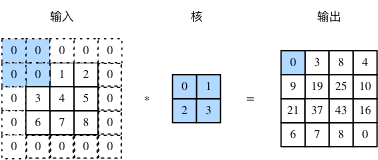

### 步幅

在互相关运算中，卷积核在输入数组上滑动，每次滑动的行数与列数即是步幅（stride）。此前我们使用的步幅都是1，图3展示了在高上步幅为3、在宽上步幅为2的二维互相关运算。


![Image Name](https://cdn.kesci.com/upload/image/q5nflohnqg.png?imageView2/0/w/640/h/640)

图3 高和宽上步幅分别为3和2的二维互相关运算

一般来说，当高上步幅为$s_h$，宽上步幅为$s_w$时，输出形状为：


$$

\lfloor(n_h+p_h-k_h+s_h)/s_h\rfloor \times \lfloor(n_w+p_w-k_w+s_w)/s_w\rfloor

$$


如果$p_h=k_h-1$，$p_w=k_w-1$，那么输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。更进一步，如果输入的高和宽能分别被高和宽上的步幅整除，那么输出形状将是$(n_h / s_h) \times (n_w/s_w)$。

当$p_h = p_w = p$时，我们称填充为$p$；当$s_h = s_w = s$时，我们称步幅为$s$。
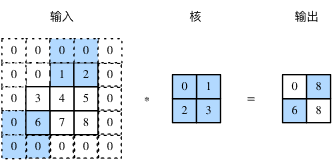

## 多输入通道和多输出通道

之前的输入和输出都是二维数组，但真实数据的维度经常更高。例如，彩色图像在高和宽2个维度外还有RGB（红、绿、蓝）3个颜色通道。假设彩色图像的高和宽分别是$h$和$w$（像素），那么它可以表示为一个$3 \times h \times w$的多维数组，我们将大小为3的这一维称为通道（channel）维。

### 多输入通道

卷积层的输入可以包含多个通道，图4展示了一个含2个输入通道的二维互相关计算的例子。


![Image Name](https://cdn.kesci.com/upload/image/q5nfmdnwbq.png?imageView2/0/w/640/h/640)

图4 含2个输入通道的互相关计算

假设输入数据的通道数为$c_i$，卷积核形状为$k_h\times k_w$，我们为每个输入通道各分配一个形状为$k_h\times k_w$的核数组，将$c_i$个互相关运算的二维输出按通道相加，得到一个二维数组作为输出。我们把$c_i$个核数组在通道维上连结，即得到一个形状为$c_i\times k_h\times k_w$的卷积核。
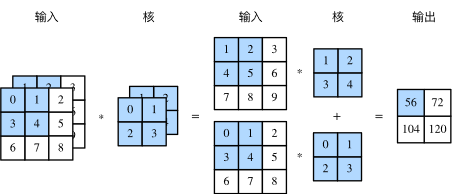

### 多输出通道

卷积层的输出也可以包含多个通道，设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_i\times k_h\times k_w$的核数组，将它们在输出通道维上连结，卷积核的形状即$c_o\times c_i\times k_h\times k_w$。

对于输出通道的卷积核，我们提供这样一种理解，一个$c_i \times k_h \times k_w$的核数组可以提取某种局部特征，但是输入可能具有相当丰富的特征，我们需要有多个这样的$c_i \times k_h \times k_w$的核数组，不同的核数组提取的是不同的特征。

### 1x1卷积层

最后讨论形状为$1 \times 1$的卷积核，我们通常称这样的卷积运算为$1 \times 1$卷积，称包含这种卷积核的卷积层为$1 \times 1$卷积层。图5展示了使用输入通道数为3、输出通道数为2的$1\times 1$卷积核的互相关计算。


![Image Name](https://cdn.kesci.com/upload/image/q5nfmq980r.png?imageView2/0/w/640/h/640)

图5 1x1卷积核的互相关计算。输入和输出具有相同的高和宽

$1 \times 1$卷积核可在不改变高宽的情况下，调整通道数。$1 \times 1$卷积核不识别高和宽维度上相邻元素构成的模式，其主要计算发生在通道维上。假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么$1\times 1$卷积层的作用与全连接层等价。
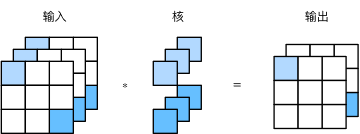

## 卷积层与全连接层的对比

二维卷积层经常用于处理图像，与此前的全连接层相比，它主要有两个优势：

一是全连接层把图像展平成一个向量，在输入图像上相邻的元素可能因为展平操作不再相邻，网络难以捕捉局部信息。而卷积层的设计，天然地具有提取局部信息的能力。

二是卷积层的参数量更少。不考虑偏置的情况下，一个形状为$(c_i, c_o, h, w)$的卷积核的参数量是$c_i \times c_o \times h \times w$，与输入图像的宽高无关。假如一个卷积层的输入和输出形状分别是$(c_1, h_1, w_1)$和$(c_2, h_2, w_2)$，如果要用全连接层进行连接，参数数量就是$c_1 \times c_2 \times h_1 \times w_1 \times h_2 \times w_2$。使用卷积层可以以较少的参数数量来处理更大的图像。

## 卷积层的简洁实现

我们使用Pytorch中的`nn.Conv2d`类来实现二维卷积层，主要关注以下几个构造函数参数：

* `in_channels` (python:int) – Number of channels in the input imag
* `out_channels` (python:int) – Number of channels produced by the convolution
* `kernel_size` (python:int or tuple) – Size of the convolving kernel
* `stride` (python:int or tuple, optional) – Stride of the convolution. Default: 1
* `padding` (python:int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0
* `bias` (bool, optional) – If True, adds a learnable bias to the output. Default: True

`forward`函数的参数为一个四维张量，形状为$(N, C_{in}, H_{in}, W_{in})$，返回值也是一个四维张量，形状为$(N, C_{out}, H_{out}, W_{out})$，其中$N$是批量大小，$C, H, W$分别表示通道数、高度、宽度。

代码讲解

In [6]:
X = torch.rand(4, 2, 3, 5)
print(X.shape)

conv2d = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3, 5), stride=1, padding=(1, 2))
Y = conv2d(X)
print('Y.shape: ', Y.shape)
print('weight.shape: ', conv2d.weight.shape)
print('bias.shape: ', conv2d.bias.shape)

torch.Size([4, 2, 3, 5])
Y.shape:  torch.Size([4, 3, 3, 5])
weight.shape:  torch.Size([3, 2, 3, 5])
bias.shape:  torch.Size([3])


## 池化

### 二维池化层

池化层主要用于缓解卷积层对位置的过度敏感性。同卷积层一样，池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出，池化层直接计算池化窗口内元素的最大值或者平均值，该运算也分别叫做最大池化或平均池化。图6展示了池化窗口形状为$2\times 2$的最大池化。


![Image Name](https://cdn.kesci.com/upload/image/q5nfob3odo.png?imageView2/0/w/640/h/640)

图6 池化窗口形状为 2 x 2 的最大池化

二维平均池化的工作原理与二维最大池化类似，但将最大运算符替换成平均运算符。池化窗口形状为$p \times q$的池化层称为$p \times q$池化层，其中的池化运算叫作$p \times q$池化。

池化层也可以在输入的高和宽两侧填充并调整窗口的移动步幅来改变输出形状。池化层填充和步幅与卷积层填充和步幅的工作机制一样。

在处理多通道输入数据时，池化层对每个输入通道分别池化，但不会像卷积层那样将各通道的结果按通道相加。这意味着池化层的输出通道数与输入通道数相等。
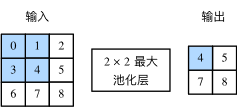

### 池化层的简洁实现

我们使用Pytorch中的`nn.MaxPool2d`实现最大池化层，关注以下构造函数参数：

* `kernel_size` – the size of the window to take a max over
* `stride` – the stride of the window. Default value is kernel_size
* `padding` – implicit zero padding to be added on both sides

`forward`函数的参数为一个四维张量，形状为$(N, C, H_{in}, W_{in})$，返回值也是一个四维张量，形状为$(N, C, H_{out}, W_{out})$，其中$N$是批量大小，$C, H, W$分别表示通道数、高度、宽度。

代码讲解

In [7]:
X = torch.arange(32, dtype=torch.float32).view(1, 2, 4, 4)
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=(2, 1))
Y = pool2d(X)
print(X)
print(Y)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]]]])
tensor([[[[ 5.,  6.,  7.,  7.],
          [13., 14., 15., 15.]],

         [[21., 22., 23., 23.],
          [29., 30., 31., 31.]]]])


平均池化层使用的是`nn.AvgPool2d`，使用方法与`nn.MaxPool2d`相同。